## Supernova 1a Cosmology

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spint
import scipy.optimize as spop
import astropy.constants as c
import astropy.units as u
import emcee
%matplotlib inline

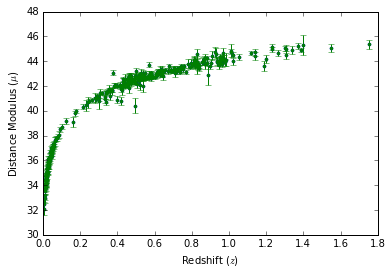

In [2]:
# 2(a) Plot Hubble diagram (mu vs. z) from data file.

z_d , mu_d, err = np.loadtxt('SN.dat.txt', skiprows=1, usecols=(1,2,3), unpack=True)

plt.plot(z_d, mu_d, '.')
plt.errorbar(z_d, mu_d, err, fmt='.')
plt.xlabel('Redshift ($z$)')
plt.ylabel('Distance Modulus ($\mu$)')


/Users/tcb/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/tcb/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


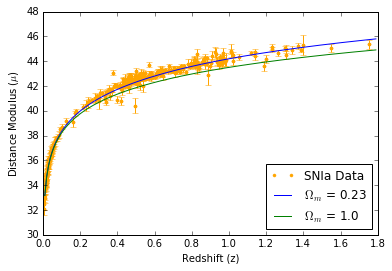

In [3]:
# 2(b) Overplot theoretical models

Omt = np.array([0.23,1.0])
ht = 0.7

def invE(z, Om):
    return 1/np.sqrt(1 - Om + Om*(1+z)**3)

def D_L(z,Om,h):
    yval = []
    for j in z:
        yval.append(spint.quad(invE, 0, j, args=(Om))[0]) 
    return yval*(1+z)*(c.c/(h*100 *u.km/u.s/u.Mpc)).to('Mpc')
    
def mu_t(z,Om,h):
    return 25+5*np.log10(D_L(z,Om,h).value)

plt.plot(z_d, mu_d, '.', label="SNIa Data", color='orange')
plt.errorbar(z_d, mu_d, err, fmt='.', color='orange')
for i in Omt:
    z_t = np.arange(0, 1.8, 0.01)
    plt.plot(z_t, mu_t(z_t,Omt[i],ht), label='$\Omega_m$ = {0}'.format(Omt[i]))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend(loc=4)

$\Omega_m = 0.23$ appears to be a slightly better fit than $\Omega_m = 1.00$, though both are decent for most of the data. Neither are the __best fit__, however.

### 3 Estimating Parameters

A measure of fit:
$$\chi^2 = \sum_i \frac{(\mu_i - \mu_{th}(z_i,\Omega_m,h))^2}{\sigma_i^2}$$
where $\mu_i$ is each data point, $\mu_{th}$ is the corresponding theoretical prediction, and
$$\sigma_i^2 = $$

(a) Minimizing $\chi^2$ will yield the best fit model.

Optimization terminated successfully.
         Current function value: 393.490325
         Iterations: 38
         Function evaluations: 74
[ 0.31828488  0.63007117]
Optimization terminated successfully.
         Current function value: 393.490325
         Iterations: 38
         Function evaluations: 74


/Users/tcb/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


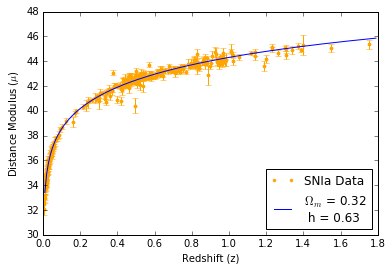

In [4]:
# (b) and (c)

def chi2(params):
    Ombf, hbf = params
    chi2 = np.sum(((mu_d - mu_t(z_d,Ombf,hbf))/err)**2)
    return chi2

print spop.fmin(chi2, [0.5,0.7])

Ombf, hbf = spop.fmin(chi2, [0.5,0.7])

z_t = np.arange(0, 1.8, 0.01)

plt.plot(z_d, mu_d, '.', label="SNIa Data", color='orange')
plt.errorbar(z_d, mu_d, err, fmt='.', color='orange')
plt.plot(z_t, mu_t(z_t,Ombf,hbf), label='$\Omega_m$ = {0}\n h = {1}'.format(round(Ombf,2),round(hbf,3)))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend(loc=4)

This fit is much better! The minimized $\chi^2$ value of 393.49 appears to be rather large, but dividing this be the number of obsevational data points (292) yields $\sim 1.35$. We can do even better.

### 4 $(\textbf{MC})^2$

(a) No, we want to maximize the likelihood.

In [6]:
# (b) Run a Markov Chain Monte Carlo to determine the best fit parameters

def lnprob(Om_MC, h_MC):
    if Om_MC < 0 or h_MC < 0:
        return -np.inf
    params = Om_MC, h_MC
    return -chi2(params)/2

nwalkers, ndim = 100, 2
p = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(Om_MC, h_MC))
sampler.run_mcmc(p, 500)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

plt.scatter(sampler.flatchain[:,0], sampler.flatchain[:,1])
plt.xlabel('ln($\Omega_m$)')
plt.ylabel('ln(h)')

# Om_MC, h_MC = ???

plt.plot(z_d, mu_d, '.', label="SNIa Data", color='orange')
plt.errorbar(z_d, mu_d, err, fmt='.', color='orange')
plt.plot(z_t, mu_t(z_t,Om_MC,h_MC), label='$\Omega_m$ = {0}\n h = {1}'.format(round(Om_MC,2),round(h_MC,3)))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend(loc=4)

NameError: name 'Om_MC' is not defined

The points should include the $\Omega_m = 1.00$ model.

(c) MCMC also gives you error bars (confidence intervals) for the parameters!

(d) $$\Omega_m = ... \pm ...$$
    $$\Omega_\lambda = ... \pm ...$$
    $$h = ... \pm ...$$
    
I would very much like to win the Nobel Prize, but I would also like to deserve it! (In other words, nothing remarkable here. What else would you expect from a undergraduate student?)